## <span style="color:black">Install needed packages</span>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install tld
!pip install pandas==1.0.5

import os
import bz2
import json
import glob
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#from utils import process_chunk, process_text, manual_extraction, ids_to_tweets, embedSentence, embedding, averageEmbedding, featurize

#Packages for url parsing
import tld
from tld import get_tld
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
from urllib.request import urlopen
#Packages for dimentionality reduction
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.tokenize.treebank import TreebankWordDetokenizer
#Packages for NLP methods
import re
import nltk
import gensim
from gensim import models
from gensim import corpora
import gensim.downloader as api
from gensim.test.utils import datapath, common_texts
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
# We need this dataset in order to use the tokenizer
nltk.download('punkt')
# Also download the list of stopwords to filter out
nltk.download('stopwords')
stemmer = PorterStemmer()

# Add constants/paths
_DATASETS_PATHS = '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import re
import nltk
# We need this dataset in order to use the tokenizer
nltk.download('punkt')
from nltk.tokenize import word_tokenize
# Also download the list of stopwords to filter out
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def process_chunk(chunk, proc_function, keywords, save_path):
    '''This function process a chunk of a dataset using the processing function given and save the preprocessed results to the path       given'''
    print(f'Processing chunk with {len(chunk)} rows')
    # Remove Phase and Num of occurences columns (not useful and redundant, respectively) to save memory
    chunk.drop(['phase', 'numOccurrences'], axis=1)
    # Apply the processing function
    chunk = proc_function(chunk, keywords)
    if len(chunk) > 0:
        print(f'There are {len(chunk)} rows that include some of the keywords')
        chunk['quotation'].to_csv(path_or_buf=save_path, compression='bz2', mode='a')
    return chunk

def manual_extraction(df, keywords):
    '''This function extracts rows in which their quotes contain any of the keywords given.'''
    results = df['quotation'].str.contains('|'.join(keywords))
    indices = list(results[results == True].index)
    return df.loc[indices,:]

def parse_title(hostname, url, positions):  
  try:
    res = get_tld(url[2:-2], as_object=True)
 
    if hostname in positions:
        return res.parsed_url.path.split('/')[positions[hostname]]
    else:
        return 0
  except:
    pass
    
def get_hostname(urls): 
   result = []

   list_urls = urls[1:-1].replace("'", "").replace(" ", "").split(",")
   for url in list_urls:
    parsed_url = urllib.parse.urlparse(url)
    print(parsed_url)
    result.append('{uri.scheme}://{uri.netloc}/'.format(uri=parsed_url))
    #print('{uri.scheme}://{uri.netloc}/'.format(uri=parsed_url))
   return result

def process_text(text):
    '''This function process the quotes by removing stopping words, lower casing all text and stemming them to their roots.'''
    # Make all the strings lowercase and remove non alphabetic characters
    text = re.sub('[^A-Za-z]', ' ', text.lower())

    # Tokenize the text; this is, separate every sentence into a list of words
    # Since the text is already split into sentences you don't have to call sent_tokenize
    tokenized_text = word_tokenize(text)

    # Remove the stopwords and stem each word to its root
    clean_text = [
        stemmer.stem(word) for word in tokenized_text
        if word not in stopwords.words('english')
    ]
    # Remember, this final output is a list of words
    return clean_text

def ids_to_tweets(tweet_ids, api):
    '''This function fetches tweets based on their IDs'''
    counter = 0
    ids = []

    with open(tweet_ids, 'r') as txtfile:
        lineReader = txtfile.readlines()
        for row in lineReader:
            ids.append(row)
            
    print(len(ids))
    sleepTime = 2
    tweets_data = {'tweet': [],
                  'date': [],
                  'location': []}

    for id in ids[10000:20000]:
        try:
            tweetFetched = api.get_status(id)
            tweets_data['tweet'] = tweetFetched.text
            tweets_data['date'] = tweetFetched.created_at
            tweets_data['location'] = tweetFetched.user.location
            df = pd.DataFrame(tweets_data, index=[id])
            # print('in')
            df.to_csv(path_or_buf='/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/tweets_data.csv.bz2',                   compression='bz2', mode='a')
            # tweets_data['fav_count'].append(tweetFetched.retweeted_status.user.favourites_count)
            time.sleep(sleepTime)

        except Exception as e:
            print(e)
            counter += 1
            time.sleep(sleepTime)
            continue
    print(counter)
    # tweets_data = pd.DataFrame.from_dict(tweets_data)
    return tweets_data

def embedSentence(sentence, word_vectors):
    '''This function maps the words in a scentence to their embeddings'''
    embed = map(lambda x: embedding(x, word_vectors), sentence)
    return list(embed)

def embedding(word, word_vectors):
    '''This function extracts word embeddings'''
    try:
        embed = word_vectors[word]
    except Exception:
        embed = word_vectors['unk']
    return embed

def averageEmbedding(sentence):
    '''This function averages words embedding in a scentence to get one embedding for each scentence'''
    average = np.mean(sentence, axis=0)
    return average

def featurize(sentence, dataframe, FeatureColumns):
    '''This function creates a dataframe containing the embeddings in each column'''
    sentence = pd.Series(sentence, index=FeatureColumns)
    dataframe = dataframe.append(sentence, ignore_index=True)
    return dataframe


def plotWords(dataframe, fileCount=0):
    '''This function plots the quotes (tSNE values) on a 2D Plane'''
    plt.figure(num=None, figsize=(12,8), dpi=300)
    ax = plt.subplot(111)
    for i in range(dataframe.shape[0]):
        plt.text(dataframe.iloc[i,0], dataframe.iloc[i,1], str(dataframe.iloc[i,2]),
                color='blue',
                fontdict={'weight': 'light', 'size':2})
    
    plt.axis('off')
    plt.savefig(fname='plot'+str(fileCount), dpi=300)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## <span style="color:black"> Generating word clouds

In [19]:
# Save the datasets paths
me_too_quotes_path = '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/metoo-extracted-quotes.csv.bz2'
#Load the saved results from previous cell
warnings.simplefilter(action='ignore', category=FutureWarning)
df = pd.read_csv(me_too_quotes_path)
df.drop(df[df == 'quotation'].index)
df = df.drop(columns='Unnamed: 0')

In [20]:
#Create a word cloud from the extracted quotes
df = df.quotation.str.replace('metoo', ' ')
#Process texts in quotes
cleaned_text = df.apply(process_text)
#Join the different processed titles together.
long_string = ','.join([text for text_list in cleaned_text.values for text in text_list])
#Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 800, background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
#Generate a word cloud
wordcloud.generate(long_string)
#Visualize the word cloud
wordcloud.to_image()
wordcloud.to_file('Wordcloud.png')


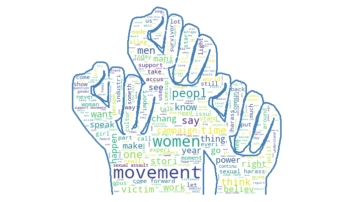

ValueError: ignored

In [24]:
#Load the saved results from previous cell
from PIL import Image
mask = np.array(Image.open('/content/drive/Shareddrives/ADA LUNATICS 2021/Milestone3/fists-removebg-preview.png'))
wc = WordCloud(mask=mask, width=1600 , height=1600, background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
#Generate a word cloud
wc.generate(long_string)
#Visualize the word cloud
#wordcloud.to_image()
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.savefig("word_fists.png")

plt.show()

wc.to_file('wc.png')

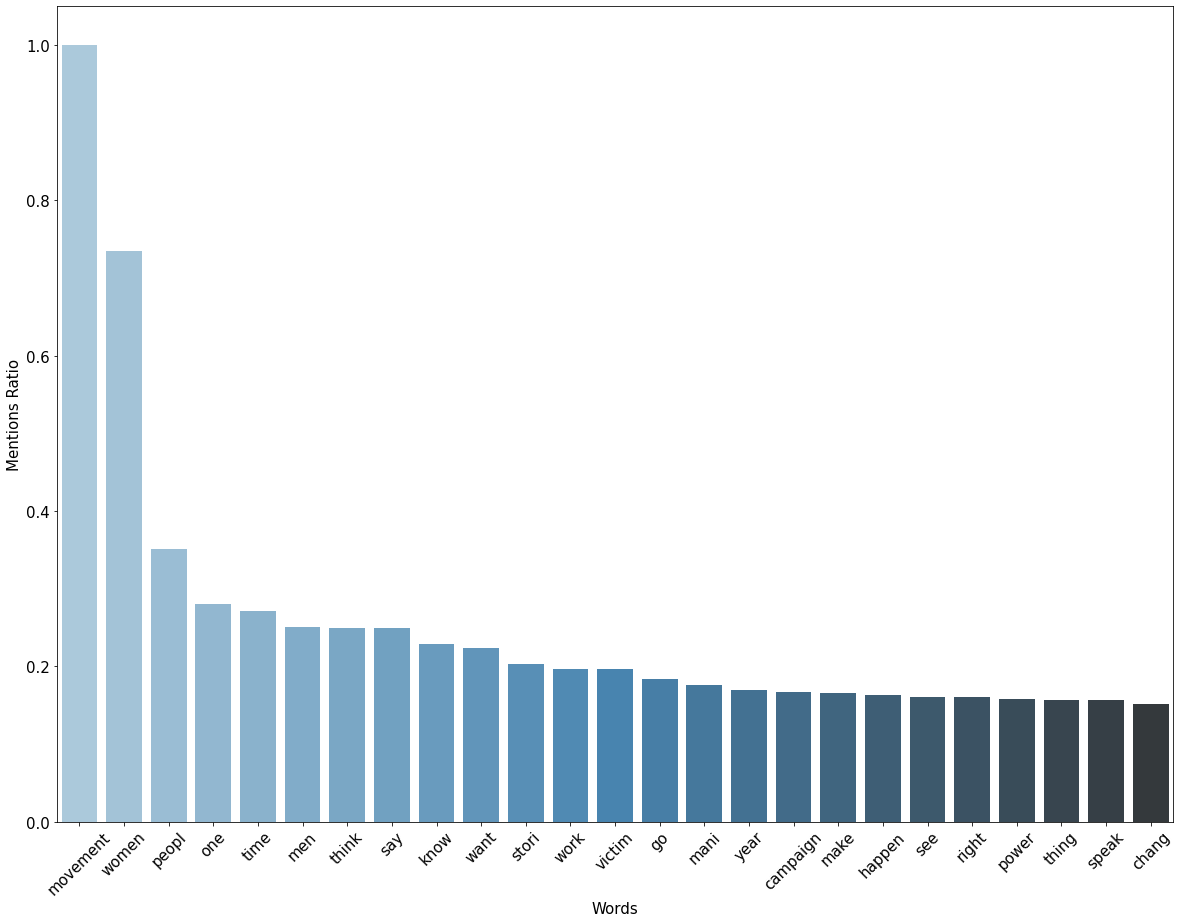

In [25]:
#Filter the top words from word cloud using an arbitrarily threshold then sort them
filtered_words = dict()
#Iterate over all the items in dictionary
for (key, value) in wordcloud.words_.items():
    #Check if item satisfies the given condition then add to new dict
    #Set an arbitrarily value to shorten the list
    if value >= 0.15:
        filtered_words[key] = value
sorted_words = dict(sorted(filtered_words.items(), key=lambda kv: kv[1], reverse=True))


#Visualize the mentions of the words generated from word cloud
words = pd.DataFrame({'words': list(sorted_words.keys()), 'mentions ratio': list(sorted_words.values())})
_, axis = plt.subplots(nrows=1, ncols=1, figsize=(20,15))
ax = sns.barplot(x="words", y="mentions ratio", data=words, capsize=.5, ax=axis, palette="Blues_d")
ax.set_xlabel('Words', fontsize=15)
ax.set_ylabel('Mentions Ratio', fontsize=15)
ax.set_xticklabels(words['words'], rotation=45)
ax.tick_params(axis='both', which='major', labelsize=15)

## <span style="color:black"> Generating sentence clouds


In [4]:
#The final keywords compiled
keywords = ['movement', 'women', 'victim', 'campaign', 'sex', 'harass', 'assualt',
           'rape', 'misconduct', 'metoo', 'timesup', 'abuse', 'workplace', 'right', 'femin']
#Save the results from keywords extraction in this path
keywords_quotes_path = '/content/drive/Shareddrives/ADA LUNATICS 2021/datasets/keywords-extracted-data.csv.bz2'

In [5]:
#Load the manually extracted data based on keywords

df = pd.read_csv(keywords_quotes_path, compression='bz2')
df = df.drop(df[df['quotation'] == 'quotation'].index)
df = df.drop(columns='Unnamed: 0')
print(f'The number of quotes that contain some of the selected keywords: {len(df)}')
df.head(10)

The number of quotes that contain some of the selected keywords: 6625708


,quoteID,quotation,speaker,qids,date,probas,urls
0,2015-08-31-000271,... a great day for veterans here in Littleton...,Jeanne Shaheen,['Q270316'],2015-08-31 02:10:00,"[['Jeanne Shaheen', '0.742'], ['None', '0.2359...",['http://www.unionleader.com/article/20150831/...
1,2015-10-29-035215,how the greatest movement came into being and ...,None,[],2015-10-29 21:25:14,"[['None', '0.5458'], ['Paul Hawken', '0.4542']]",['https://medium.com/enspiral-tales/bioneers-d...
2,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",Bernie Sanders,['Q359442'],2015-10-25 14:12:35,"[['Bernie Sanders', '0.5395'], ['None', '0.312...",['http://examiner.com/article/bernie-sanders-s...
3,2015-10-17-000460,[ This is ] defamation. I'm hitting back. [ Me...,Meghan King Edmonds,['Q20684375'],2015-10-17 13:35:01,"[['Meghan King Edmonds', '0.7414'], ['None', '...",['http://www.inquisitr.com/2500312/vicki-gunva...
4,2015-09-04-030275,I ain't going nowhere. I'm going to be right h...,Letroy Guion,['Q13219370'],2015-09-04 12:36:42,"[['Letroy Guion', '0.7119'], ['None', '0.2804'...",['http://www.channel3000.com/sports/packers/Pa...
5,2015-12-01-033189,"I am confident enough, optimistic enough to sa...",Frank-Walter Steinmeier,['Q76658'],2015-12-01 08:47:00,"[['Frank-Walter Steinmeier', '0.6923'], ['Mr H...",['http://express.co.uk/news/politics/623296/EU...
6,2015-02-03-000382,A careful analysis of the career histories of ...,Lisa Mainiero,['Q53121229'],2015-02-03 17:22:00,"[['Lisa Mainiero', '0.9511'], ['None', '0.0489']]",['http://www.forbes.com/sites/bonniemarcus/201...
7,2015-01-27-023512,I am honored and proud to raise awareness for ...,Joe Haden,['Q733737'],2015-01-27 13:25:00,"[['Joe Haden', '0.5859'], ['None', '0.3302'], ...",['http://www.istockanalyst.com/article/viewart...
8,2015-09-10-001454,"A couple bumps and bruises, but all right.",James Blake,"['Q350362', 'Q53333']",2015-09-10 06:31:35,"[['James Blake', '0.7538'], ['None', '0.2422']...",['http://rss.cnn.com/c/35494/f/676993/s/49bd29...
9,2015-09-23-032351,I am proud that once again I got to fly the So...,President Barack Obama,['Q76'],2015-09-23 06:04:06,"[['President Barack Obama', '0.6547'], ['None'...",['http://www.bdlive.co.za/business/management/...


In [6]:
def plotWords(dataframe, fileCount=0):
    '''This function plots the quotes (tSNE values) on a 2D Plane'''
    plt.figure(num=None, figsize=(12,8), dpi=300)
    ax = plt.subplot(111)
    for i in range(dataframe.shape[0]):
        plt.text(dataframe.iloc[i,0], dataframe.iloc[i,1], str(dataframe.iloc[i,2]),
                color='blue',
                fontdict={'weight': 'light', 'size':2})
    
    plt.axis('off')
    plt.savefig(fname='plot'+str(fileCount), dpi=300)

In [ ]:
#Scale between 0 and 1
scaler = MinMaxScaler()
data = pd.DataFrame(df.quotation.sample(100))
data["xpos"] =  np.random.randint(0,20,100).tolist()
data["ypos"] = np.random.randint(0,20,100).tolist()
data = data[["xpos", "ypos", "quotation"]]
plotWords(data,fileCount=1 )

In [55]:
data = data[["xpos", "ypos", "quotation"]]
data

,xpos,ypos,quotation
2597841,37,28,Hunger doesn't take a break and neither do we ...
2056370,43,66,She is the right leader to take on such a task.
3582026,85,72,His groundbreaking work not only helped shape ...
5903523,46,57,"People don't know the history of those times, ..."
4502679,59,94,"a feminist for due process,"
...,...,...,...
4146712,29,34,"I've been doing this for 40 years now, I've re..."
5372813,50,45,"It didn't matter who the victims were,"
2500732,37,94,It just makes it that much more difficult for ...
4843075,57,89,and today I can't tell you how many victims th...


In [ ]:

#data = scaler.fit_transform(tsneDF.iloc[:, [0,1]])
#Plot the tSNE values woth their corresponding scentences
#tsneDF.iloc[:, [0,1]] = data
plotWords(data)